## Week 2: Capstone Project: Task 2

**Tasks to accomplish**

1. Exploratory analysis - perform a thorough exploratory analysis of the data, understanding the distribution of words and relationship between the words in the corpora.
1. Understand frequencies of words and word pairs - build figures and tables to understand variation in the frequencies of words and word pairs in the data.

**Questions to consider**

1. **Some words are more frequent than others - what are the distributions of word frequencies?**
1. **What are the frequencies of 2-grams and 3-grams in the dataset?**
1. **How many unique words do you need in a frequency sorted dictionary to cover 50% of all word instances in the language? 90%?**
1. How do you evaluate how many of the words come from foreign languages?
1. Can you think of a way to increase the coverage -- identifying words that may not be in the corpora or using a smaller number of words in the dictionary to cover the same number of phrases?

### 0. Environmet Settings

In [1]:
library(data.tree)
library(DiagrammeR)
library(dplyr)
library(ggplot2)
library(igraph)
library(influenceR)
library(plyr)
library(RColorBrewer)
library(SnowballC)
library(stopwords)
library(stringi)
library(stringr)
library(tidyr)
library(tidytext)
library(tokenizers)
library(tm)
library(wordcloud)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘influenceR’


The following objects are masked from ‘package:igraph’:

    betweenness, constraint


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked fr

### 1. Preparation

In [2]:
# file path for english data
blogs_path <- "~/Soft/Rtest/JHU_capstone_project_data/final/en_US/en_US.blogs.txt"
news_path <- "~/Soft/Rtest/JHU_capstone_project_data/final/en_US/en_US.news.txt"
twitter_path <- "~/Soft/Rtest/JHU_capstone_project_data/final/en_US/en_US.twitter.txt"

# load data
blogs <- readLines(blogs_path, encoding = "UTF-8", skipNul = TRUE)
news <- readLines(news_path, encoding = "UTF-8", skipNul = TRUE)
twitter <- readLines(twitter_path, encoding = "UTF-8", skipNul = TRUE)

# number of characters per line
blogs_nchar <- nchar(blogs)
news_nchar <- nchar(news)
twitter_nchar <- nchar(twitter)

In [3]:
# boxplot(
#     blogs_nchar
#     , news_nchar
#     , twitter_nchar
#     , log = "y"
#     , names = c("blogs", "news", "twitter")
#     , ylab = "log(Number of Characters)"
#     , xlab = "Type"
#     , title = "Distribution of Characters/Line"
# )

In [3]:
# Read the data files into data frames
blogs <- data.frame(text = blogs)
news <- data.frame(text = news)
twitter <- data.frame(text = twitter)

In [4]:
# Sampling
set.seed(1565)
sample_pct <- 0.1

blogs_sample <- blogs %>% sample_n(., nrow(blogs)*sample_pct)
news_sample <- news %>% sample_n(., nrow(news)*sample_pct)
twitter_sample <- twitter %>% sample_n(., nrow(twitter)*sample_pct)

In [5]:
# Create aggregate sample
agg_sample <- bind_rows(
    mutate(blogs_sample, source = 'blogs')
    , mutate(news_sample, source = 'news')
    , mutate(twitter_sample, source = 'twitter')
)
# change agg_sample$source type: chr --> factor
agg_sample$source <- factor(agg_sample$source)

In [6]:
head(agg_sample)

,text,source
,<chr>,<fct>
1,"The surprising thing is, the majority of these people are wearing suits, and are what seem to be highly educated people. But it seems as though they switch their brain off when using the public transport system.",blogs
2,"Let’s face it, archery has always been awesome. For centuries, it was one of the best methods for getting food. Can’t run down a deer? Fine, just shoot it with your trusty bow instead. You needed to know how to hunt if you wanted to survive. Then there was archery in warfare. That enemy with the sword can’t get you if you shoot him first. Unless, he’s heavily armored. Although, for the record, a tossed battle axe pawns a bow and arrow any day. Of course, if you threw your battle axe in the middle of a battle, you would also be out of luck.",blogs
3,“I do.” I say flatly.,blogs
4,Here is a craft I make with my students using a toilet paper roll:,blogs
5,"1. Carpool, walk, or ride the bus to school or work. If you live within a couple of blocks from school or work, there’s no reason why you should be driving or riding there. You’re inside over eight hours a day, so why not enjoy the morning and afternoon walks as a way to prepare/ decompress for the day? If you live further away, it’s more eco-friendly to hitch a ride with friends or to take the big yellow school bus. You wouldn’t want to deprive your kids of school bus memories, would you? Plus, it might make your afternoons a bit less stressful.",blogs
6,Something needs to be worked out of you. Thirty is a watershed. You should be happy but aren’t. You need to clear your head.,blogs


In [7]:
# Create filters: non-alphanumeric's, url's, repeated letters
replace_reg <- "[^[:alpha:][:space:]]*"
replace_url <- "http[^[:space:]]*"
replace_aaa <- "\\b(?=\\w*(\\w)\\1)\\w+\\b"  

# Clean sample
clean_sample <- agg_sample %>%
    mutate(text = str_replace_all(text, replace_reg, "")) %>%
    mutate(text = str_replace_all(text, replace_url, "")) %>%
    mutate(text = str_replace_all(text, replace_aaa, "")) #%>%
#    mutate(text = iconv(text, "ASCII//TRANSLIT"))

In [8]:
rm(blogs
   , blogs_nchar
   , news
   , news_nchar
   , twitter
   , twitter_nchar
   , replace_reg
   , replace_url
   , replace_aaa
  )

In [9]:
# stop words and swear words
data("stop_words")
swear_words <- read.csv("/home/yanyuan/Soft/swear-words/en")
swear_words <- unnest_tokens(swear_words, word, X2g1c)

# clean for stop and swear words
tidy_data <- clean_sample %>%
    unnest_tokens(word, text) %>%
     anti_join(swear_words) %>%
     anti_join(stop_words)

Joining, by = "word"

Joining, by = "word"



In [11]:
head(tidy_data)

,source,word
,<fct>,<chr>
1.1,blogs,surprising
1.5,blogs,majority
1.8,blogs,people
1.10,blogs,wearing
1.11,blogs,suits
1.17,blogs,highly


### 2. Word Frequencies

Some words are more frequent than others - what are the distributions of word frequencies? 

In [12]:
data_count <- tidy_data %>% summarise(keys = n_distinct(word))
data_count

keys
<int>
159836


In [13]:
word_freq <- count(tidy_data, vars = "word") %>%
mutate(proportion = freq / sum(freq)) %>%
arrange(desc(proportion))

In [14]:
head(word_freq, 10)

,word,freq,proportion
,<chr>,<int>,<dbl>
1,im,24515,0.007367132
2,time,21417,0.006436135
3,dont,17721,0.005325431
4,day,16846,0.005062480
5,people,15887,0.004774286
6,life,8922,0.002681197
7,rt,8755,0.002631011
8,home,8089,0.002430868
9,night,7442,0.002236435


So that the top 10 words with highest frequencies are : `im`, `time`, `dont`, `day`, `people`, `life`, `rt`, `home`, `night`, `lol`. We can show that in a plot

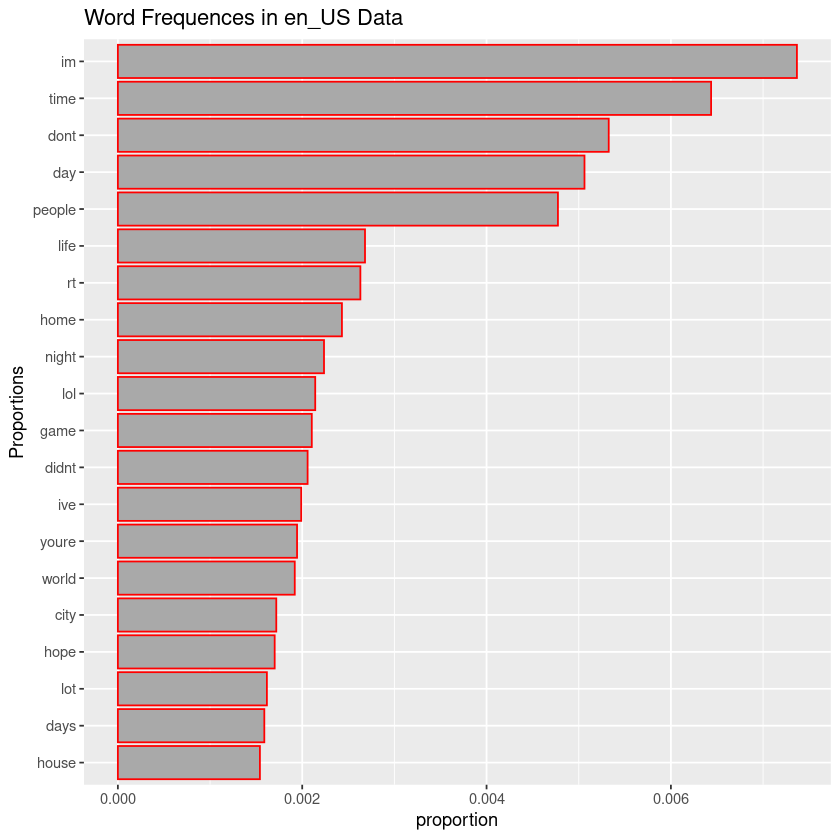

In [15]:
word_freq %>%
    top_n(20, proportion) %>%
    mutate(word = reorder(word, proportion)) %>%
    ggplot(aes(word, proportion)) + geom_col(col = "red", fill = "darkgrey") + labs(title = "Word Frequences in en_US Data") + xlab("Proportions") + coord_flip()

In [55]:
png(file = "data/uni-gram.png")
word_freq %>%
    top_n(20, proportion) %>%
    mutate(word = reorder(word, proportion)) %>%
    ggplot(aes(word, proportion)) + geom_col(col = "red", fill = "darkgrey") + labs(title = "Word Frequences in en_US Data") + xlab("Proportions") + coord_flip()
dev.off()

png 
  2

Furthermore, we plot word distribution by sources

In [16]:
head(tidy_data)

,source,word
,<fct>,<chr>
1.1,blogs,surprising
1.5,blogs,majority
1.8,blogs,people
1.10,blogs,wearing
1.11,blogs,suits
1.17,blogs,highly


In [17]:
word_freq_source <- count(tidy_data, vars = c("word", "source")) %>%
    group_by(source) %>%
    mutate(proportion = freq / sum(freq)) %>%
    spread(source, proportion) %>%
    gather(source, proportion, `blogs`:`twitter`) %>%
    arrange(desc(proportion), desc(freq)) %>%
    filter(proportion > 0.0005) %>%
    mutate(word = reorder(word, proportion))

In [ ]:
g <- NULL
g <- ggplot(data = word_freq_source, aes(word, proportion))
g <- g + geom_col(col = "blue", fill = "darkgrey")
g <- g + coord_flip()
g <- g + facet_grid(~source, scales = "free")
g

In [56]:
png(file = "data/uni-gram-source.png")
g <- NULL
g <- ggplot(data = word_freq_source, aes(word, proportion))
g <- g + geom_col(col = "blue", fill = "darkgrey")
g <- g + coord_flip()
g <- g + facet_grid(~source, scales = "free")
g
dev.off()

png 
  2

### 3. Word Coverage

How many unique words do you need in a frequency sorted dictionary to cover 50% of all word instances in the language? 90%? 

In [19]:
cover_50 <- count(tidy_data, vars = "word") %>%
mutate(proportion = freq / sum(freq)) %>%
arrange(desc(proportion)) %>%
mutate(coverage = cumsum(proportion)) %>%
filter(coverage <= 0.5)

nrow(cover_50)

[1] 1316

In [20]:
cover_90 <- count(tidy_data, vars = "word") %>%
mutate(proportion = freq / sum(freq)) %>%
arrange(desc(proportion)) %>%
mutate(coverage = cumsum(proportion)) %>%
filter(coverage <= 0.9)

nrow(cover_90)

[1] 17761

In [35]:
head(cover_90)

,word,freq,proportion,coverage
,<chr>,<int>,<dbl>,<dbl>
1,im,24515,0.007367132,0.007367132
2,time,21417,0.006436135,0.013803267
3,dont,17721,0.005325431,0.019128698
4,day,16846,0.005062480,0.024191178
5,people,15887,0.004774286,0.028965464
6,life,8922,0.002681197,0.031646661


In [52]:
# word cloud
png(file="data/word_cloud.png")
cover_90 %>% 
    with(wordcloud(word, freq , max.words = 500
                    , colors = brewer.pal(6, "Dark2")
                    , random.order = FALSE))
dev.off()

png 
  2

In [37]:
saveRDS(cover_90, file = "data/cover_90.RDS")

So that the number of words a dictionary needs to cover frequent words are:
- 1305 words, to cover 50% of all
- 17470 words, to cover 90% of all

### 4. Frequencies of Bigrams

In [21]:
# create bigrams by source
bigram_data <- as.data.frame(clean_sample) %>% 
    unnest_tokens(output = bigram, input = text, token = 'ngrams', n = 2) #%>%
#    mutate(proportion = n / sum(n)) #%>%

In [22]:
bigram_cover_90 <- bigram_data %>%
    count(c("bigram","source"))  %>%
    mutate(proportion = freq / sum(freq)) %>%
    arrange(desc(proportion)) %>%
    mutate(coverage = cumsum(proportion)) %>%
    filter(coverage <= 0.9)

In [23]:
head(bigram_cover_90)

,bigram,source,freq,proportion,coverage
,<chr>,<fct>,<int>,<dbl>,<dbl>
1,of the,blogs,19104,0.002138569,0.002138569
2,of the,news,19100,0.002138121,0.004276690
3,in the,news,18265,0.002044648,0.006321338
4,in the,blogs,15620,0.001748558,0.008069896
5,to the,news,10076,0.001127943,0.009197839
6,to the,blogs,9833,0.001100741,0.010298579


So that the number of bigrams to get 90% coverage of all bigrams are

In [24]:
nrow(bigram_cover_90)

[1] 1947044

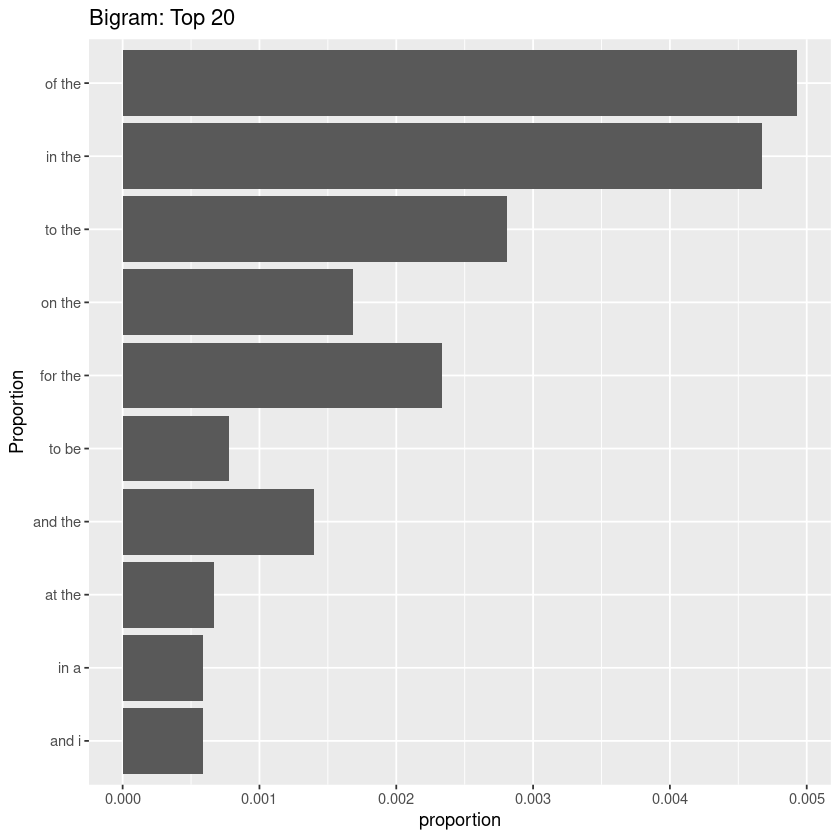

In [25]:
# plot top 20 frequences
bigram_cover_90 %>%
    top_n(20, proportion) %>%
    mutate(bigram = reorder(bigram, proportion)) %>%
    ggplot(aes(bigram, proportion)) + geom_col() + xlab("Proportion") + ggtitle("Bigram: Top 20") + coord_flip()

### 5. Frequencies of Trigrams

In [26]:
# create bigrams by source
trigram_data <- as.data.frame(clean_sample) %>% 
    unnest_tokens(output = trigram, input = text, token = 'ngrams', n = 3) #%>%
#    mutate(proportion = n / sum(n)) #%>%


In [27]:
trigram_cover_90 <- trigram_data %>%
    count(c("trigram","source"))  %>%
    mutate(proportion = freq / sum(freq)) %>%
    arrange(desc(proportion)) %>%
    mutate(coverage = cumsum(proportion)) %>%
    filter(coverage <= 0.9) 

So that the number of bigrams to get 90% coverage of all bigrams are

In [28]:
nrow(trigram_cover_90)

[1] 5677948

In [29]:
head(trigram_cover_90, 20)

,trigram,source,freq,proportion,coverage
,<chr>,<fct>,<int>,<dbl>,<dbl>
1,thanks for the,twitter,2409,2.696720e-04,0.0002696720
2,one of the,news,1493,1.671317e-04,0.0004368037
3,one of the,blogs,1480,1.656765e-04,0.0006024802
4,a lot of,blogs,1255,1.404892e-04,0.0007429693
5,a lot of,news,1127,1.261604e-04,0.0008691297
6,the of the,blogs,876,9.806255e-05,0.0009671923
7,thank you for,twitter,837,9.369675e-05,0.0010608890
8,i love you,twitter,833,9.324898e-05,0.0011541380
9,cant wait to,twitter,787,8.809957e-05,0.0012422376


In [57]:
png(file = 'data/tri-gram.png')
# plot top 20 frequences
trigram_cover_90 %>%
    top_n(20, proportion) %>%
    mutate(trigram = reorder(trigram, proportion)) %>%
    ggplot(aes(trigram, proportion)) + geom_col() + xlab("Proportion") + ggtitle("Trigram: Top 20") + coord_flip()
dev.off()

png 
  2

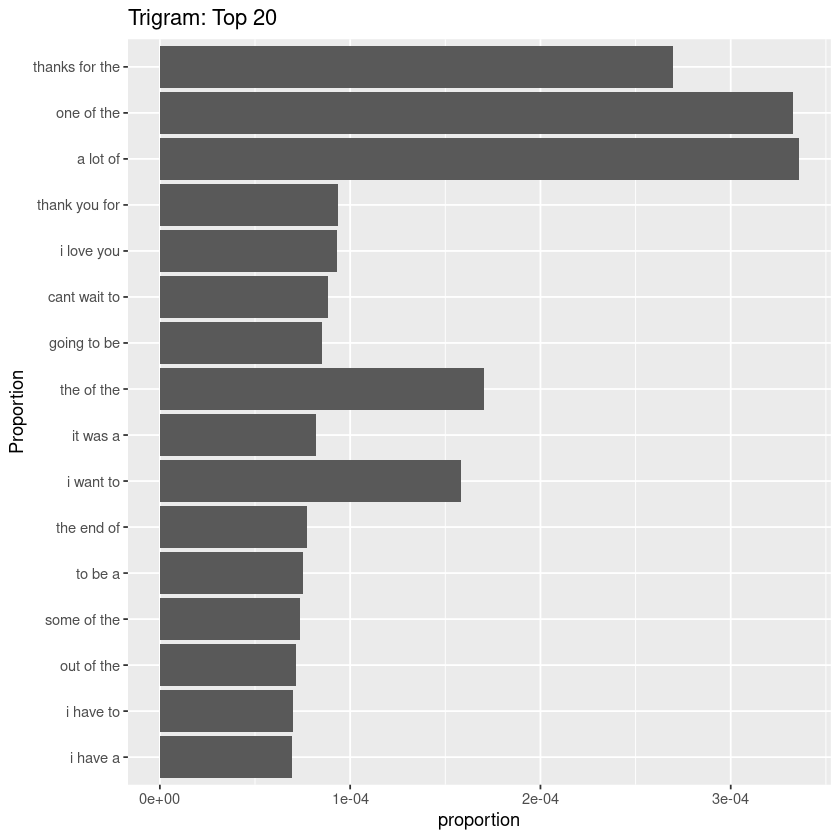

In [30]:
# plot top 20 frequences
trigram_cover_90 %>%
    top_n(20, proportion) %>%
    mutate(trigram = reorder(trigram, proportion)) %>%
    ggplot(aes(trigram, proportion)) + geom_col() + xlab("Proportion") + ggtitle("Trigram: Top 20") + coord_flip()

## Week 2: Capstone Project: Task 3

The goal here is to build your first simple model for the relationship between words. This is the first step in building a predictive text mining application. You will explore simple models and discover more complicated modeling techniques.

**Tasks to accomplish**
1. Build basic n-gram model - using the exploratory analysis you performed, build a basic n-gram model for predicting the next word based on the previous 1, 2, or 3 words.
1. Build a model to handle unseen n-grams - in some cases people will want to type a combination of words that does not appear in the corpora. Build a model to handle cases where a particular n-gram isn't observed.

**Questions to consider**
1. How can you efficiently store an n-gram model (think Markov Chains)?
1. How can you use the knowledge about word frequencies to make your model smaller and more efficient?
1. How many parameters do you need (i.e. how big is n in your n-gram model)?
1. Can you think of simple ways to "smooth" the probabilities (think about giving all n-grams a non-zero probability even if they aren't observed in the data) ?
1. How do you evaluate whether your model is any good?
1. How can you use backoff models to estimate the probability of unobserved n-grams?

**Hints, tips, and tricks**

As you develop your prediction model, two key aspects that you will have to keep in mind are the size and runtime of the algorithm. These are defined as:
- Size: the amount of memory (physical RAM) required to run the model in R
- Runtime: The amount of time the algorithm takes to make a prediction given the acceptable input

Your goal for this prediction model is to minimize both the size and runtime of the model in order to provide a reasonable experience to the user.

Keep in mind that currently available predictive text models can run on mobile phones, which typically have limited memory and processing power compared to desktop computers. Therefore, you should consider very carefully (1) how much memory is being used by the objects in your workspace; and (2) how much time it is taking to run your model. Ultimately, your model will need to run in a Shiny app that runs on the shinyapps.io server.

Tips, tricks, and hints

Here are a few tools that may be of use to you as you work on their algorithm:

- `object.size()`: this function reports the number of bytes that an R object occupies in memory
- `Rprof()`: this function runs the profiler in R that can be used to determine where bottlenecks in your function may exist. The profr package (available on CRAN) provides some additional tools for visualizing and summarizing profiling data.
- `gc()`: this function runs the garbage collector to retrieve unused RAM for R. In the process it tells you how much memory is currently being used by R.

There will likely be a tradeoff that you have to make in between size and runtime. For example, an algorithm that requires a lot of memory, may run faster, while a slower algorithm may require less memory. You will have to find the right balance between the two in order to provide a good experience to the user.